# Debug.ipynb
It seems that network version and LUT version doesn't agree with each other. Let's find outwhy. 

First, let's import some libraries and define some useful helper functions, and load the model. 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import sys
sys.path.insert(0, "../")
from importlib import reload

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from common import network
import model
from model import SPF_LUT_DFC, SPF_LUT_net, round_func

def showimg(image, plot=plt, title=None):
    # N,C,H,W -> H,W,C
    image=np.array(image.detach().cpu())
    N,C,H,W=image.shape
    assert N==1
    image=image.reshape(C,H,W).transpose(1,2,0)
    if plot==plt: plt.figure()
    plot.imshow(image, cmap='gray' if C==1 else None, vmin=0, vmax=1)
    if title:
        plot.title.set_text(title)

def psnr(a,b):
    from common.utils import PSNR, _rgb2ycbcr
    def transform(x):
        x=x*255
        x=x.squeeze(0)
        x=torch.transpose(x, 0, 1)
        x=torch.transpose(x, 1, 2)
        x=torch.clamp(x, 0, 255)
        x=torch.round(x).to(torch.uint8)
        x = x.detach().cpu().numpy()
        return x

    a=transform(a)
    b=transform(b)
    left, right = _rgb2ycbcr(a)[:,:,0], _rgb2ycbcr(b)[:,:,0]
    result=PSNR(left, right, 4)
    return result,a,b

def load_nets():
    reload(network)
    reload(model)
    from model import SPF_LUT_DFC, SPF_LUT_net, round_func

    sample_size=3
    load_iter=20_0000
    folder="spf_lut_x4_autosample_res"

    srnet=SPF_LUT_net(sample_size, nf=64, scale=4)
    lm = torch.load(os.path.join("../models/", folder, 'Model_{:06d}.pth'.format(load_iter)), weights_only=False)
    srnet.load_state_dict(lm, strict=True)
    srnet=srnet.cuda()

    lutnet=SPF_LUT_DFC(
        lut_folder=os.path.join("../models/", folder),
        stages="unused", modes="sdy", lutName="spf_lut_x4", upscale=4, interval=4,
        compressed_dimensions="xyzt", diagonal_width=2, sampling_interval=5, sample_size=sample_size,
        phase="no train"
    )
    lutnet=lutnet.cuda()

    return srnet, lutnet

def load_img(name):
    x=Image.open(name)
    x=np.array(x)
    x=torch.tensor(x).cuda().permute((2,0,1)).unsqueeze(0).to(torch.float32)/255
    return x

srnet, lutnet = load_nets()

# Make sure load_iter is right: The weights should be exported from that network.
assert (srnet.convblock1.module_dict["DepthwiseBlock0_s"].sampler.sampler.weight == lutnet.sampler_s1c0_s.sampler.weight).all()

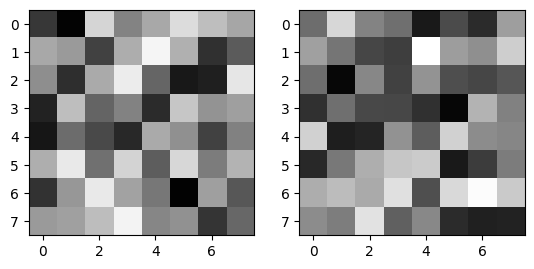

In [2]:
fig, (a,b) = plt.subplots(1,2)

shape=(1,1,8,8)
small_img=torch.rand(shape).cuda()
# small_img = torch.ones(1,1,4,4)*0.6
# small_img = torch.tensor([0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]).to(torch.float32).reshape(1,1,4,4)
showimg(small_img, a)

small_img2=torch.rand(shape).cuda()
showimg(small_img2, b)

Let's write a function that does inference on a specific stage on both LUT and network, so that we can compare both sides easily. 

In [3]:
def inference(stage, x, prevx):
    # stage: 1-6

    if 1<=stage<=4 or stage==6:
        # srnet
        convblock=getattr(srnet, f"convblock{stage}") if stage!=6 else srnet.upblock
        y = convblock(x, prevx)
        if stage==6:
            avg_factor=len(srnet.modes)
            bias=0
            norm=255.0
            y=round_func(y/avg_factor+bias) / norm
        else:
            avg_factor=len(srnet.modes)*4
            bias=127
            norm=255.0
            y = round_func(torch.clamp(y/avg_factor+bias, 0, 255)) / norm
        y_srnet = y

        # lutnet
        x = x * 255
        prevx = prevx * 255 if prevx is not None else None
        channels = 4 if stage==6 else 1
        scale = lutnet.upscale if stage==6 else 1
        pred = 0
        pad = lutnet.sample_size-1
        outc_list = [2,2,2,1,None,1]
        out_c = outc_list[stage-1]
        for channel in range(channels):
            x_c = x[:,channel:channel+1,:,:]
            prevx_c = prevx[:,channel:channel+1,:,:] if prevx is not None else None
            for mode in lutnet.modes:
                key_c1 = f"s{stage}c{channel}_{mode}_compress1"
                key_c2 = f"s{stage}c{channel}_{mode}_compress2"
                weight_c1 = getattr(lutnet, 'weight_'+key_c1)
                weight_c2 = getattr(lutnet, 'weight_'+key_c2)

                sampler_key = f"sampler_s{stage}c{channel}_{mode}"
                sampler = getattr(lutnet, sampler_key)
                res_w_key = f"residual_s{stage}c{channel}_{mode}"
                res_w = getattr(lutnet, res_w_key)
                for r in [0,1,2,3]:
                    x_rot = torch.rot90(x_c, r, [2,3])
                    x_pad = F.pad(x_rot, (0, pad, 0, pad), mode='replicate')
                    prevx_rot = torch.rot90(prevx_c, r, [2,3]) if prevx_c is not None else None
                    prevx_pad = F.pad(prevx_rot, (0, pad, 0, pad), mode='replicate') if prevx_rot is not None else None

                    interpolated = lutnet.InterpTorchBatch(
                        weight_c1, weight_c2, sampler, res_w,
                        scale, out_c, mode, x_pad, prevx_pad, pad
                    )
                    rot_back = torch.rot90(interpolated, -r, [2,3])
                    pred += rot_back
                    pred = round_func(pred)
        avg_factor = len(lutnet.modes)*4
        if stage==6: bias, norm = 0, 1
        else: bias, norm = 127, 255.0
        y_lutnet = round_func(torch.clamp(pred/avg_factor+bias, 0, 255)) / 255.0

        return y_srnet, y_lutnet
    else:
        # srnet
        y = round_func(torch.tanh(srnet.ChannelConv(x)) * 127)
        y_srnet = round_func(torch.clamp(y+127, 0, 255)) / 255.0

        # lutnet
        x = x * 255
        # prevx = prevx * 255
        key = f"s5_channel"
        weight = getattr(lutnet, 'weight_'+key)
        y = lutnet.InterpTorchBatch_channel(weight, 4, x)
        y_lutnet = round_func(torch.clamp(y+127, 0, 255))
        y_lutnet = y_lutnet/255

        return y_srnet, y_lutnet

sr shape torch.Size([1, 4, 8, 8]) value tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6235, device='cuda:0', grad_fn=<MaxBackward1>)
lut shape torch.Size([1, 4, 8, 8]) value tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6157, device='cuda:0', grad_fn=<MaxBackward1>)


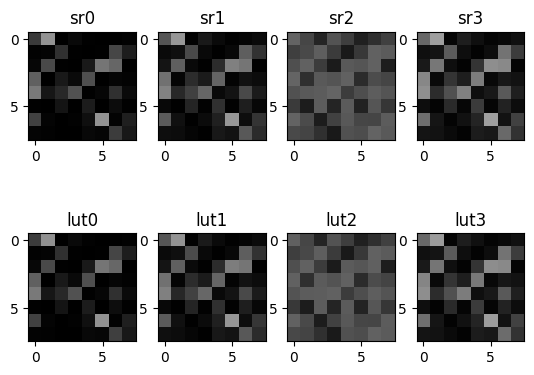

In [4]:
srnet, lutnet = load_nets()
stage=5
sry, luty = inference(
    stage,
    small_img.repeat(1,4,1,1),
    small_img2.repeat(1,4,1,1),
    # None
)
assert sry.shape==luty.shape

print("sr shape", sry.shape, "value", sry.min(), sry.max())
print("lut shape", luty.shape, "value", luty.min(), luty.max())
b,c,h,w = sry.shape

fig, splts = plt.subplots(2, c)
for channel in range(c):
    showimg(sry[:, channel:channel+1, :, :], splts[0][channel] if c>1 else splts[0], title=f"sr{channel}")
    showimg(luty[:, channel:channel+1, :, :], splts[1][channel] if c>1 else splts[1], title=f"lut{channel}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011764707..0.909804].


22.751161941451965

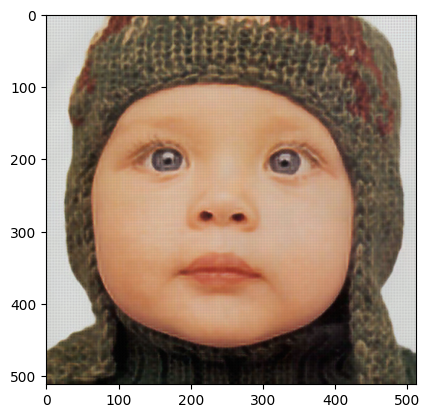

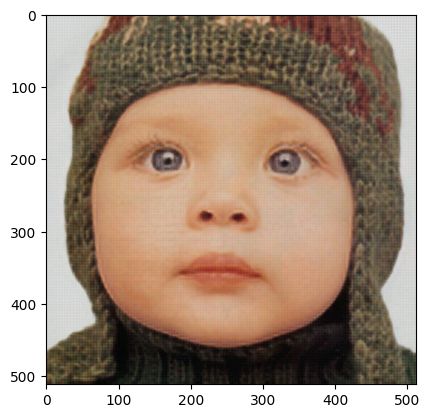

In [5]:
# x = small_img
img=Image.open("../data/SRBenchmark/Set5/LR_bicubic/X4/babyx4.png")
x = np.array(img)
x = torch.tensor(x).cuda()
x = x.permute((2,0,1)).unsqueeze(0).to(torch.float32)/255

gt=Image.open("../data/SRBenchmark/Set5/HR/baby.png")
gt = np.array(gt)
gt = torch.tensor(gt).cuda().permute((2,0,1)).unsqueeze(0).to(torch.float32)/255

B,C,H,W = x.shape
x = x.reshape((B*C, 1, H, W))

clp={
    "atol": 45/255,
    # "rtol": 1e-5,
}

sr_refine_list=[]
lut_refine_list=[]

# Stage 1
x1 = x
sry, luty = inference(1, x1, None)
srref, srx = torch.chunk(sry, 2, 1)
lutref, lutx = torch.chunk(luty, 2, 1)
sr_refine_list.append(srref)
lut_refine_list.append(lutref)
assert torch.allclose(srx, lutx, **clp)
assert torch.allclose(srref, lutref, **clp)

# Stage 2
x2 = srx
sry, luty = inference(2, x2, x1)
srref, srx = torch.chunk(sry, 2, 1)
lutref, lutx = torch.chunk(luty, 2, 1)
sr_refine_list.append(srref)
lut_refine_list.append(lutref)
assert torch.allclose(srx, lutx, **clp)
assert torch.allclose(srref, lutref, **clp)

# Stage 3
x3 = srx
sry, luty = inference(3, x3, x2)
srref, srx = torch.chunk(sry, 2, 1)
lutref, lutx = torch.chunk(luty, 2, 1)
sr_refine_list.append(srref)
lut_refine_list.append(lutref)
assert torch.allclose(srx, lutx, **clp)
assert torch.allclose(srref, lutref, **clp)

# Stage 4
x4 = srx
sry, luty = inference(4, x4, x3)
sr_refine_list.append(sry)
lut_refine_list.append(luty)
assert torch.allclose(sry, luty, **clp)

# Stage 5
x5 = torch.cat(sr_refine_list, 1)
sry, luty = inference(5, x5, None)
assert torch.allclose(sry, luty, **clp)

# Stage 6
x6 = sry
x6_prev = torch.cat([x1,x2,x3,x4], dim=1)
sry, luty = inference(6, x6, x6_prev)

sry = sry.reshape((B, C, H*srnet.upscale, W*srnet.upscale))
luty = luty.reshape((B, C, H*lutnet.upscale, W*lutnet.upscale))
# fig, (pa, pb) = plt.subplots(2)
showimg(sry)
showimg(luty)
assert torch.allclose(sry, luty, **clp)
p,a,b=psnr(sry, gt)
p

In [3]:
psnrs=[]
for img_name in "baby bird butterfly head woman".split(" "):
    hrfname="../data/SRBenchmark/Set5/HR/"+img_name+".png"
    gt=load_img(hrfname)
    lrfname="../data/SRBenchmark/Set5/LR_bicubic/X4/"+img_name+"x4.png"
    img=load_img(lrfname)
    netsr=srnet.forward(img)
    p,a,b=psnr(netsr, gt)
    psnrs.append(p)
psnrs, sum(psnrs)/len(psnrs)

([22.751161941451965,
  27.129142830995793,
  21.719722815493622,
  26.76964911750094,
  22.6482603297953],
 24.203587407047525)

In [ ]:
sr

In [6]:
srnet, lutnet = load_nets()
dict(lutnet.named_parameters()).keys()

dict_keys(['weight_s1c0_s_compress1', 'weight_s1c0_s_compress2', 'residual_s1c0_s', 'weight_s2c0_s_compress1', 'weight_s2c0_s_compress2', 'residual_s2c0_s', 'weight_s3c0_s_compress1', 'weight_s3c0_s_compress2', 'residual_s3c0_s', 'weight_s4c0_s_compress1', 'weight_s4c0_s_compress2', 'residual_s4c0_s', 'weight_s6c0_s_compress1', 'weight_s6c0_s_compress2', 'residual_s6c0_s', 'weight_s6c1_s_compress1', 'weight_s6c1_s_compress2', 'residual_s6c1_s', 'weight_s6c2_s_compress1', 'weight_s6c2_s_compress2', 'residual_s6c2_s', 'weight_s6c3_s_compress1', 'weight_s6c3_s_compress2', 'residual_s6c3_s', 'weight_s1c0_d_compress1', 'weight_s1c0_d_compress2', 'residual_s1c0_d', 'weight_s2c0_d_compress1', 'weight_s2c0_d_compress2', 'residual_s2c0_d', 'weight_s3c0_d_compress1', 'weight_s3c0_d_compress2', 'residual_s3c0_d', 'weight_s4c0_d_compress1', 'weight_s4c0_d_compress2', 'residual_s4c0_d', 'weight_s6c0_d_compress1', 'weight_s6c0_d_compress2', 'residual_s6c0_d', 'weight_s6c1_d_compress1', 'weight_s6c1_